In [1]:
# ================================================================
# IMPORTS
# ================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets, transforms, models
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

In [2]:
# ================================================================
# DEVICE
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# ================================================================
# TRANSFORMS
# ================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    ])

eval_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ])

# For normalization in loops
mean = torch.tensor(imagenet_mean, device=device).view(1, 3, 1, 1)
std  = torch.tensor(imagenet_std,  device=device).view(1, 3, 1, 1)

In [4]:
from torch.utils.data import Dataset

class CaltechMappedDataset(Dataset):
    def __init__(self, base_dataset, indices, class_to_new_idx, transform=None):
        """
        base_dataset: Caltech101 with transform=None (PIL images)
        indices: list of indices to keep (filtered classes)
        class_to_new_idx: dict mapping class_name -> new int label [0..num_classes-1]
        transform: augmentation / preprocessing to apply (train or eval)
        """
        self.base_dataset = base_dataset
        self.indices = indices
        self.class_to_new_idx = class_to_new_idx
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        img, orig_label = self.base_dataset[base_idx]  # orig_label is 0..101

        # get original class name
        cls_name = self.base_dataset.categories[orig_label]

        # remap to [0..num_classes-1]
        new_label = self.class_to_new_idx[cls_name]

        # apply transform
        if self.transform is not None:
            img = self.transform(img)

        return img, new_label


In [5]:
# =========================================================
# TRANSFORM DATASET WRAPPER
# =========================================================

class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset              # subset of your dataset
        self.transform = transform        # transform to apply

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]     # get item from Subset
        if self.transform:
            img = self.transform(img)     # apply transform
        return img, label


In [6]:
# ================================================================
# LOAD DATASET
# ================================================================
data_path = "./data"
base_dataset = datasets.Caltech101(root=data_path, download=True, transform=None)

100%|██████████| 137M/137M [00:08<00:00, 17.0MB/s]


In [7]:
# ================================================================
# FILTER CLASSES WITH > 100 IMAGES
# ================================================================
ccounts = Counter()
for label in base_dataset.y:
    cls = base_dataset.categories[label]
    ccounts[cls] += 1

classes_over_100 = [cls for cls, c in ccounts.items() if c > 100]
selected_classes = classes_over_100[:10]
class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

selected_indices = []
for idx, label in enumerate(base_dataset.y):
    class_name = base_dataset.categories[label]
    if class_name in selected_classes:
        selected_indices.append(idx)

In [8]:
# ================================================================
# BUILD SUBSET WITH ONLY SELECTED CLASSES
# ================================================================
num_classes = len(selected_classes)
print("Selected classes:", selected_classes)
print("num_classes:", num_classes)

# full mapped dataset (still unsplit)
full_mapped_dataset = CaltechMappedDataset(
    base_dataset=base_dataset,
    indices=selected_indices,
    class_to_new_idx=class_to_new_idx,
    transform=None  # we’ll set transforms AFTER split
)

print("Total images in selected subset:", len(full_mapped_dataset))


Selected classes: ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'airplanes', 'bonsai', 'car_side', 'chandelier', 'ketch', 'watch']
num_classes: 10
Total images in selected subset: 3379


Selected classes: ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'airplanes', 'bonsai', 'car_side', 'chandelier', 'ketch', 'watch']


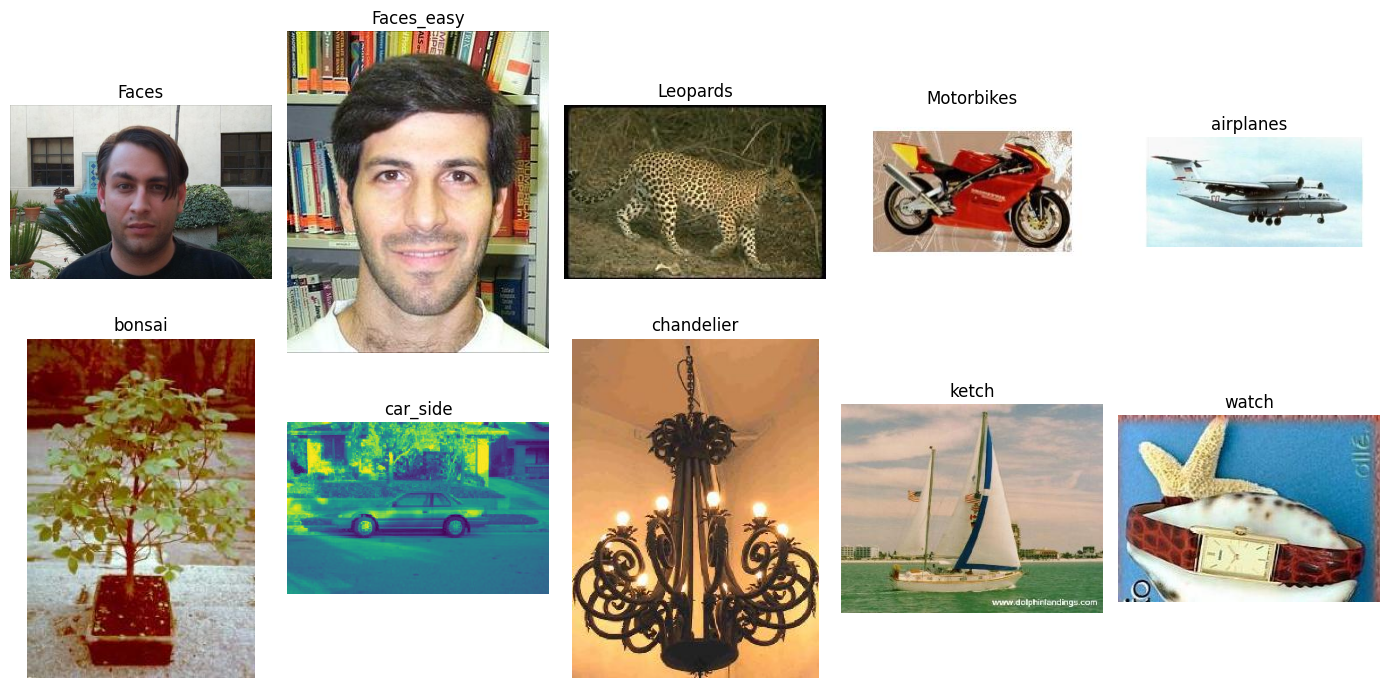

In [9]:
import random
def show_selected_classes(base_dataset, selected_classes):
    """
    base_dataset: original Caltech101 dataset (transform=None)
    selected_classes: list of class names chosen for the project
    """

    print("Selected classes:", selected_classes)

    plt.figure(figsize=(14, 7))

    for i, cls in enumerate(selected_classes):
        # --- find all indices belonging to this class ---
        indices = [
            idx for idx, label in enumerate(base_dataset.y)
            if base_dataset.categories[label] == cls
        ]

        # --- pick a random sample ---
        sample_idx = random.choice(indices)

        img, _ = base_dataset[sample_idx]  # PIL image

        img_np = np.array(img)  # convert to NumPy

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_np)
        plt.title(cls)
        plt.axis("off")

    plt.tight_layout()
    plt.show
def show_selected_classes(base_dataset, selected_classes):
    print("Selected classes:", selected_classes)

    plt.figure(figsize=(14, 7))

    for i, cls in enumerate(selected_classes):
        indices = [
            idx for idx, label in enumerate(base_dataset.y)
            if base_dataset.categories[label] == cls
        ]

        sample_idx = random.choice(indices)
        img, _ = base_dataset[sample_idx]

        img_np = np.array(img)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_np)
        plt.title(cls)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
show_selected_classes(base_dataset, selected_classes)

In [10]:
# ================================================================
# TRAIN / VAL / TEST SPLIT
# ================================================================
dataset_size = len(full_mapped_dataset)
train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)
test_size  = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_mapped_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 2365, Val: 506, Test: 508


In [11]:
# ================================================================
# WRAP SPLITS WITH TRANSFORMS
# ================================================================
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform   = eval_transforms
test_dataset.dataset.transform  = eval_transforms

In [12]:
# ================================================================
# DATALOADERS (BATCH SIZE WILL CHANGE DURING TUNING)
# ================================================================
def create_loaders(batch_size):
    pin_mem = True if device.type == "cuda" else False
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=2, pin_memory=pin_mem)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=2, pin_memory=pin_mem)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=2, pin_memory=pin_mem)
    return train_loader, val_loader, test_loader


In [13]:
# ================================================================
# MODEL: RESNET18 (10 CLASSES)
# ================================================================
def build_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze all pretrained layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace final FC layer for your number of selected classes
    model.fc = nn.Linear(512, num_classes)

    return model.to(device)


In [14]:
# ================================================================
# TRAIN / EVAL UTILITIES (NO EARLY STOP HERE, USED FOR TUNING)
# ================================================================
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # Ensure 3 channels (safety, though convert("RGB") should guarantee it)
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)

        # Normalize
        images = (images - mean) / std

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)

            images = (images - mean) / std

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [15]:
# ================================================================
# HYPERPARAMETER TUNING
# ================================================================
learning_rates = [1e-3, 5e-4]
batch_sizes    = [32, 64]
num_epochs_tuning = 15   # small number for quick comparison

criterion = nn.CrossEntropyLoss()
tuning_results = []

exp_id = 0
for lr in learning_rates:
    for bs in batch_sizes:
        exp_id += 1
        print(f"\n===== Experiment {exp_id}: LR={lr}, BatchSize={bs} =====")

        train_loader, val_loader, _ = create_loaders(bs)

        model_hp = build_model(num_classes)
        optimizer = optim.Adam(model_hp.fc.parameters(), lr=lr, weight_decay=1e-4)

        best_val_acc = 0.0
        best_epoch = 0

        for epoch in range(num_epochs_tuning):
            train_loss, train_acc = train_one_epoch(model_hp, train_loader, optimizer, criterion, device)
            val_loss, val_acc     = evaluate(model_hp, val_loader, criterion, device)

            print(
                f"Epoch {epoch+1}/{num_epochs_tuning} "
                f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% "
                f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%"
            )

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch + 1

        tuning_results.append({
            "experiment": exp_id,
            "learning_rate": lr,
            "batch_size": bs,
            "best_val_acc": best_val_acc,
            "best_epoch": best_epoch
        })

# Print tuning summary
print("\n===== Hyperparameter Tuning Summary =====")
print(f"{'Exp':<5} {'LR':<10} {'Batch':<8} {'Best Val Acc (%)':<18} {'Best Epoch':<11}")
for r in tuning_results:
    print(
        f"{r['experiment']:<5} "
        f"{r['learning_rate']:<10} "
        f"{r['batch_size']:<8} "
        f"{r['best_val_acc']*100: <18.2f} "
        f"{r['best_epoch']:<11}"
    )

# Pick best config
best_cfg = max(tuning_results, key=lambda d: d["best_val_acc"])
best_lr = best_cfg["learning_rate"]
best_bs = best_cfg["batch_size"]

print("\nBest config:")
print(best_cfg)


===== Experiment 1: LR=0.001, BatchSize=32 =====
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


Epoch 1/15 | Train Loss: 0.7587, Train Acc: 79.79% | Val Loss: 0.2501, Val Acc: 95.26%
Epoch 2/15 | Train Loss: 0.1897, Train Acc: 96.49% | Val Loss: 0.1321, Val Acc: 98.02%
Epoch 3/15 | Train Loss: 0.1232, Train Acc: 98.18% | Val Loss: 0.1010, Val Acc: 99.01%
Epoch 4/15 | Train Loss: 0.0885, Train Acc: 98.99% | Val Loss: 0.0788, Val Acc: 98.62%
Epoch 5/15 | Train Loss: 0.0645, Train Acc: 99.20% | Val Loss: 0.0733, Val Acc: 98.62%
Epoch 6/15 | Train Loss: 0.0571, Train Acc: 99.32% | Val Loss: 0.0634, Val Acc: 98.81%
Epoch 7/15 | Train Loss: 0.0486, Train Acc: 99.24% | Val Loss: 0.0574, Val Acc: 98.62%
Epoch 8/15 | Train Loss: 0.0402, Train Acc: 99.66% | Val Loss: 0.0528, Val Acc: 98.81%
Epoch 9/15 | Train Loss: 0.0369, Train Acc: 99.58% | Val Loss: 0.0450, Val Acc: 99.01%
Epoch 10/15 | Train Loss: 0.0324, Train Acc: 99.70% | Val Loss: 0.0455, Val Acc: 98.81%
Epoch 11/15 | Train Loss: 0.0325, Train Acc: 99.62% | Val Loss: 0.0439, Val Acc: 98.81%
Epoch 12/15 | Train Loss: 0.0294, Train A

In [16]:
# ================================================================
# FINAL TRAINING WITH BEST HYPERPARAMETERS + EARLY STOPPING
# ================================================================
train_loader, val_loader, test_loader = create_loaders(best_bs)
model_final = build_model(num_classes)
optimizer_final = optim.Adam(model_final.fc.parameters(), lr=best_lr, weight_decay=1e-4)

epochs = 15
patience = 3
best_val_loss = np.inf
patience_counter = 0
best_weights = None

train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("\nStarting final training with best hyperparameters...\n")

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_final, train_loader, optimizer_final, criterion, device)
    val_loss, val_acc     = evaluate(model_final, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model_final.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

if best_weights is not None:
    model_final.load_state_dict(best_weights)


Starting final training with best hyperparameters...

Epoch 1/15
Train Loss: 0.8021 | Train Acc: 77.84%
Val Loss:   0.2534 | Val Acc:   96.05%

Epoch 2/15
Train Loss: 0.2042 | Train Acc: 96.32%
Val Loss:   0.1521 | Val Acc:   96.44%

Epoch 3/15
Train Loss: 0.1173 | Train Acc: 98.73%
Val Loss:   0.1065 | Val Acc:   98.02%

Epoch 4/15
Train Loss: 0.0895 | Train Acc: 98.99%
Val Loss:   0.0802 | Val Acc:   99.21%

Epoch 5/15
Train Loss: 0.0733 | Train Acc: 99.07%
Val Loss:   0.0712 | Val Acc:   98.81%

Epoch 6/15
Train Loss: 0.0565 | Train Acc: 99.45%
Val Loss:   0.0728 | Val Acc:   98.42%

Epoch 7/15
Train Loss: 0.0528 | Train Acc: 99.28%
Val Loss:   0.0596 | Val Acc:   98.81%

Epoch 8/15
Train Loss: 0.0415 | Train Acc: 99.45%
Val Loss:   0.0579 | Val Acc:   98.81%

Epoch 9/15
Train Loss: 0.0443 | Train Acc: 99.20%
Val Loss:   0.0487 | Val Acc:   99.01%

Epoch 10/15
Train Loss: 0.0343 | Train Acc: 99.58%
Val Loss:   0.0468 | Val Acc:   98.81%

Epoch 11/15
Train Loss: 0.0294 | Train Acc: 

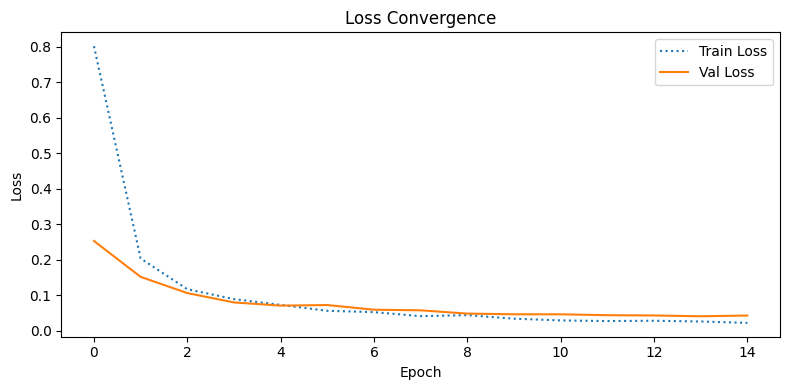

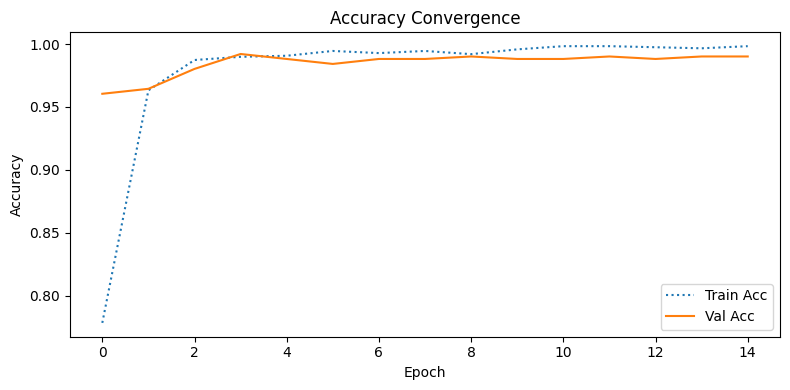

In [17]:
# ================================================================
# PLOT CONVERGENCE (LOSS + ACC)
# ================================================================
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", linestyle="dotted")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Convergence")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(train_accs, label="Train Acc", linestyle="dotted")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Convergence")
plt.legend()
plt.tight_layout()
plt.show()




===== FINAL TEST RESULTS =====
Test Accuracy: 99.41%

Per-class Test Metrics:
Faces           | Prec: 1.000 | Rec: 0.986 | F1: 0.993 | Support: 73
Faces_easy      | Prec: 0.985 | Rec: 1.000 | F1: 0.992 | Support: 66
Leopards        | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 20
Motorbikes      | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 121
airplanes       | Prec: 0.991 | Rec: 1.000 | F1: 0.996 | Support: 116
bonsai          | Prec: 1.000 | Rec: 0.944 | F1: 0.971 | Support: 18
car_side        | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 19
chandelier      | Prec: 0.933 | Rec: 1.000 | F1: 0.966 | Support: 14
ketch           | Prec: 1.000 | Rec: 0.944 | F1: 0.971 | Support: 18
watch           | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 43

Classification Report (Test Set):
              precision    recall  f1-score   support

       Faces       1.00      0.99      0.99        73
  Faces_easy       0.99      1.00      0.99        66
    Leopards       1.00      1.

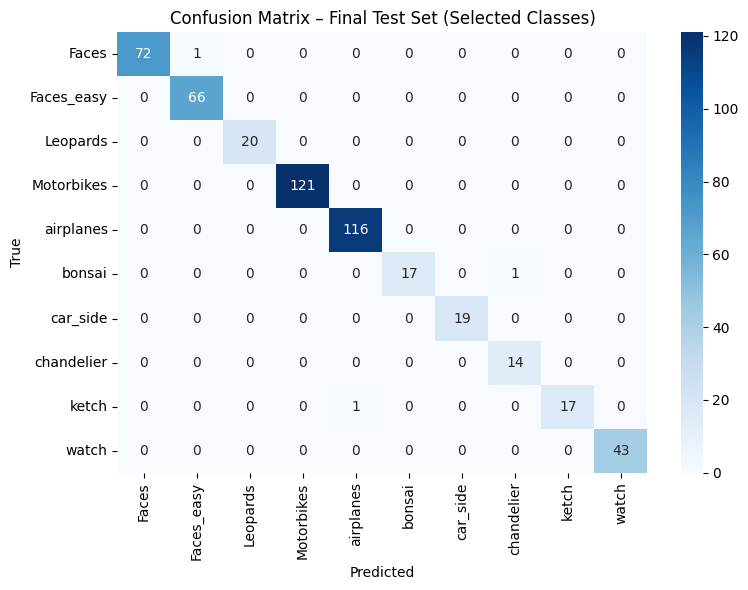

In [18]:
# ================================================================
# FINAL EVALUATION ON TEST SET
# ================================================================
model_final.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        images = (images - mean) / std

        outputs = model_final(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_acc = accuracy_score(all_labels, all_preds)
print(f"\n===== FINAL TEST RESULTS =====")
print(f"Test Accuracy: {test_acc*100:.2f}%")

prec, rec, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

print("\nPer-class Test Metrics:")
for i, cls_name in enumerate(selected_classes):
    print(f"{cls_name:15s} | Prec: {prec[i]:.3f} | Rec: {rec[i]:.3f} | F1: {f1[i]:.3f} | Support: {support[i]}")

print("\nClassification Report (Test Set):")
print(classification_report(all_labels, all_preds, target_names=selected_classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=selected_classes,
            yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Final Test Set (Selected Classes)")
plt.tight_layout()
plt.show()

In [19]:
# Overall accuracy
val_acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# Per-class precision, recall, F1
prec, rec, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

print("\nPer-class metrics:")
for i, cls_name in enumerate(selected_classes):
    print(f"{cls_name:15s} | Prec: {prec[i]:.3f} | Rec: {rec[i]:.3f} | F1: {f1[i]:.3f} | Support: {support[i]}")

# Macro / weighted metrics
print("\nClassification Report (macro/weighted):")
print(classification_report(all_labels, all_preds, target_names=selected_classes, zero_division=0))


Validation Accuracy: 99.41%

Per-class metrics:
Faces           | Prec: 1.000 | Rec: 0.986 | F1: 0.993 | Support: 73
Faces_easy      | Prec: 0.985 | Rec: 1.000 | F1: 0.992 | Support: 66
Leopards        | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 20
Motorbikes      | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 121
airplanes       | Prec: 0.991 | Rec: 1.000 | F1: 0.996 | Support: 116
bonsai          | Prec: 1.000 | Rec: 0.944 | F1: 0.971 | Support: 18
car_side        | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 19
chandelier      | Prec: 0.933 | Rec: 1.000 | F1: 0.966 | Support: 14
ketch           | Prec: 1.000 | Rec: 0.944 | F1: 0.971 | Support: 18
watch           | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | Support: 43

Classification Report (macro/weighted):
              precision    recall  f1-score   support

       Faces       1.00      0.99      0.99        73
  Faces_easy       0.99      1.00      0.99        66
    Leopards       1.00      1.00      1.00        20
  

In [20]:
# ================================================================
# FINE-TUNING AND ITERATION
# ================================================================

best_lr = 1e-3
best_bs = 32

# Rebuild loaders with best batch size
train_loader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=best_bs, shuffle=False)

# Rebuild model starting from pretrained weights
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_classes = 10

# 1) Freeze everything first
for p in model_ft.parameters():
    p.requires_grad = False

# 2) Unfreeze last residual block and FC for fine-tuning
for p in model_ft.layer4.parameters():
    p.requires_grad = True
model_ft.fc = nn.Linear(512, num_classes)
for p in model_ft.fc.parameters():
    p.requires_grad = True

model_ft = model_ft.to(device)

# Use smaller LR for fine-tuning
optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=best_lr,
    weight_decay=1e-4
)
criterion = nn.CrossEntropyLoss()

# Reuse your existing train_one_epoch / evaluate functions
epochs_finetune = 13
best_val_acc = 0.0
best_weights = None

for epoch in range(epochs_finetune):
    train_loss, train_acc = train_one_epoch(model_ft, train_loader, optimizer_ft, criterion, device)
    val_loss, val_acc     = evaluate(model_ft, val_loader, criterion, device)

    print(f"[Fine-tune] Epoch {epoch+1}/{epochs_finetune} "
          f"| Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = model_ft.state_dict()

# Load best fine-tuned weights
if best_weights is not None:
    model_ft.load_state_dict(best_weights)


[Fine-tune] Epoch 1/13 | Train Acc: 96.49% | Val Acc: 98.81%
[Fine-tune] Epoch 2/13 | Train Acc: 99.15% | Val Acc: 99.41%
[Fine-tune] Epoch 3/13 | Train Acc: 99.70% | Val Acc: 99.01%
[Fine-tune] Epoch 4/13 | Train Acc: 99.49% | Val Acc: 99.01%
[Fine-tune] Epoch 5/13 | Train Acc: 99.75% | Val Acc: 99.41%
[Fine-tune] Epoch 6/13 | Train Acc: 99.83% | Val Acc: 99.41%
[Fine-tune] Epoch 7/13 | Train Acc: 99.92% | Val Acc: 99.41%
[Fine-tune] Epoch 8/13 | Train Acc: 99.83% | Val Acc: 99.01%
[Fine-tune] Epoch 9/13 | Train Acc: 99.24% | Val Acc: 98.42%
[Fine-tune] Epoch 10/13 | Train Acc: 98.77% | Val Acc: 98.62%
[Fine-tune] Epoch 11/13 | Train Acc: 99.07% | Val Acc: 93.28%
[Fine-tune] Epoch 12/13 | Train Acc: 99.28% | Val Acc: 99.41%
[Fine-tune] Epoch 13/13 | Train Acc: 99.96% | Val Acc: 99.41%


In [21]:
# ============================================
# FINAL MODEL TESTING
# ============================================
test_loss, test_acc = evaluate(model_ft, test_loader, criterion, device)

print("\n===== FINAL TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")



===== FINAL TEST RESULTS =====
Test Loss: 0.0027
Test Accuracy: 100.00%


In [22]:
torch.save(model_final.state_dict(), "resnet18_caltech10.pth")
